# P4 Advanced Lane Lines
## Thomas J. Chmielenski
## September 2017
---

In this project, the goal is to write a software pipeline to identify the lane boundaries in a video from a front-facing camera on a car. The camera calibration images, test road images, and project videos are available  in this project repository.

More specifically, the goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### 1.  Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.


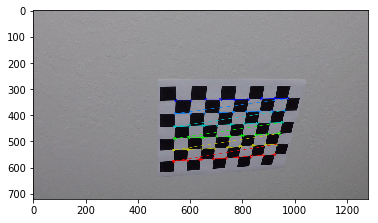

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle

%matplotlib inline

def  compute_camera_calibration_coefficents(calibration_images ='./camera_cal/calibration*.jpg', nx = 9, ny =6):
    images = glob.glob(calibration_images)

    # Arrays to store object points and image points from all the images
    objpoints =[] #3D points in real world space
    imgpoints =[] #2D points in image plane

    # Prepare object points, like (0,0, 0), (1,0,0), (2,0,0), ...,  (7,5,0)
    objp = np.zeros((ny * nx, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2) 

    for fname in images:
        # Read om each image
        img = mpimg.imread(fname)
    
        # Convert image to grayscale
        # mpimg.imread() this will read in an RGB image
        # cv2.imread () or glob API this will read in a BGR image
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
        # If corners are found, add object points, image points
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
               
            img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            if (len(objpoints) == 1):                               
                # first out the first image
                plt.imshow(img)
                plt.savefig('./output_images/chessboard.png')
                plt.show()

    # To calibrate a camera
    # gray.shape[::-1] is equivalent to img.shape[0:2] <-- first two values of a color image shape
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return (ret, mtx, dist, rvecs, tvecs)

nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y
(ret, mtx, dist, rvecs, tvecs) = compute_camera_calibration_coefficents (calibration_images =  './camera_cal/calibration*.jpg', nx = nx, ny = ny)

dist_pickle = {}
dist_pickle['mtx'] = mtx
dist_pickle['dist'] = dist
pickle.dump(dist_pickle, open( "./calibration_pickle.p", "wb"))

# Undistort
#dst = cv2.undistort(img, mtx, dist, None, mtx)


### 2.  Apply a distortion correction to raw images.